In [2]:
import sys
sys.path.insert(0, '../')

import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from PIL import Image, UnidentifiedImageError
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch
import torchvision.models as models
import torch.nn as nn
from tqdm.auto import tqdm

from src.features import build_features

c:\Users\sofia\Documents\Datascientest\Classification_project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### single picture

In [2]:
#selecting a random picture
import os
import random

path = './../data/raw/selected'
pics = [f for f in os.listdir(path) if f.endswith('.tif')]
pic = random.choice(pics)
label = pic[:-4] + '.txt'



In [3]:
print('Selected picture:', pic)
print('Selected label:', label)

Selected picture: 50374904-4905.tif
Selected label: 50374904-4905.txt


In [9]:
pic

'50374904-4905.tif'

In [8]:
processed_images

(False, "'str' object has no attribute '__array_interface__'", None)

In [4]:
#cnn preprocessing
processed_images = build_features.cnn_process_image(path + '/' + pic)
cnn_pic = processed_images[2]

#plot the image
image = cnn_pic.clone().detach()
image = image.squeeze(0)
image = image.permute(1, 2, 0)
image = image.numpy()
plt.imshow(image)
plt.show()


#print the label
with open(path + '/' + label) as f:
    real_label = f.read()
    print(real_label)




AttributeError: 'NoneType' object has no attribute 'clone'

In [6]:
#loading the cnn model
cnn_model = models.efficientnet_b1()
cnn_model.classifier[1] = nn.Linear(cnn_model.classifier[1].in_features, 16)
cnn_model.load_state_dict(torch.load('./../models/model_efnet_b1.pth'))

<All keys matched successfully>

In [7]:
#making a random prediction with the loaded model
cnn_model.eval()
cnn_output = cnn_model(cnn_pic)
cnn_output = nn.functional.softmax(cnn_output, dim=1)
cnn_output[0]

TypeError: conv2d() received an invalid combination of arguments - got (NoneType, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!NoneType!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!NoneType!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)


In [171]:
#printing the prediction
print('CNN prediction:', cnn_output.argmax().item())
print('Real label:', real_label)

CNN prediction: 1
Real label: 14


In [172]:
#nlp preprocessing
with Image.open(path + '/' + pic) as img:
            nlp_pic = np.array(img)
nlp_pic = Image.fromarray(nlp_pic)
nlp_pic = nlp_pic.resize((1000, 1000))
nlp_pic = np.array(nlp_pic)
nlp_text = build_features.ocr_pytesseract(nlp_pic)
nlp_text = build_features.text_cleaning(nlp_text)



In [4]:
#loading the nlp model
with open('./../models/nlp_model.pkl', 'rb') as file:
    nlp_model = pickle.load(file)

In [174]:
#making a random prediction with the loaded model
nlp_output = nlp_model.predict_proba([nlp_text])
nlp_output

array([[1.87468606e-03, 1.40558430e-03, 1.02417402e-03, 5.11780237e-04,
        5.76449204e-04, 2.24041571e-03, 1.52628840e-03, 7.38099472e-04,
        6.61889034e-04, 1.13107361e-03, 1.11435840e-03, 1.09256143e-03,
        1.68028939e-03, 9.80554706e-04, 9.82107432e-01, 1.33436422e-03]])

In [175]:
#printing the prediction
print('NLP prediction:', nlp_output.argmax())
print('Real label:', real_label)

NLP prediction: 14
Real label: 14


In [176]:
#adding the probability of the two models
cnn_output = cnn_output.detach().numpy()

output = cnn_output + nlp_output
prediction = np.argmax(output)
print('Real label', real_label)
print('CNN prediction:', cnn_output.argmax().item())
print('NLP prediction:', nlp_output.argmax())
print('Final prediction:', prediction)

print("#"*20)
print('CNN probability:', cnn_output[0][cnn_output.argmax().item()])
print('NLP probability:', nlp_output[0][nlp_output.argmax()])
print('Final probability:', output[0][prediction])

Real label 14
CNN prediction: 1
NLP prediction: 14
Final prediction: 14
####################
CNN probability: 0.40744382
NLP probability: 0.9821074318074582
Final probability: 1.3290473531865477


### test set

In [10]:
rvlcdip_test_path = "./../data/raw/selected"

#puting all the files, pictures and targets into a list
picture_list = []
target_list = []
file_list = []
for file in glob.glob(f"{rvlcdip_test_path}/*.tif"):
    try:
        with Image.open(file) as img:
            img_array = np.array(img) #save to a numpy array because there were too much files open otherwise.
            picture_list.append(img_array)

        target_file = file.replace(".tif", ".txt")
        with open(target_file, 'r', encoding='utf-8') as f:
            target = f.read()
            target_list.append(target)
            file_list.append(file.split('\\')[-1])
    except UnidentifiedImageError:
        print(f"Le fichier {file} n'a pas pu être ouvert.")
        continue

#stitching in a dataframe file name, picture and text
df = pd.DataFrame(columns=['filename', 'picture', 'target'])
df['filename'] = file_list
df['picture'] = picture_list
df['target'] = target_list
df['target'] = df['target'].astype(int)

c:\Users\sofia\Documents\Datascientest\Classification_project\.venv\lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Le fichier ./../data/raw/selected\2500126531_2500126536.tif n'a pas pu être ouvert.


In [3]:
#loading the cnn model
cnn_model = models.efficientnet_b0()
cnn_model.classifier[1] = nn.Linear(cnn_model.classifier[1].in_features, 16)
cnn_model.load_state_dict(torch.load('./../models/cnn_model.pth'))

<All keys matched successfully>

In [4]:
#loading the cnn model
cnn_model = models.efficientnet_b1()
cnn_model.classifier[1] = nn.Linear(cnn_model.classifier[1].in_features, 16)
cnn_model.load_state_dict(torch.load('./../models/model_efnet_b1.pth'))

<All keys matched successfully>

In [5]:
#loading the nlp model
with open('./../models/nlp_model.pkl', 'rb') as file:
    nlp_model = pickle.load(file)

In [13]:
#preprocessing CNN
df['cnn_processed_images'] = df['picture'].apply(build_features.cnn_process_image)

In [14]:
#preprocessing NLP
df['picture_resize'] = df.apply(lambda x: build_features.image_resize(x['picture']), axis=1)
df['ocr_text'] = build_features.pytesseract_ocr(df.picture_resize)
df['clean_text'] = build_features.clean_text(df.ocr_text)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\sofia\Documents\Datascientest\Classification_project\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\sofia\AppData\Local\Temp\ipykernel_12892\1426745596.py", line 2, in <module>
    df['picture_resize'] = df.apply(lambda x: build_features.image_resize(x['picture']), axis=1)
  File "c:\Users\sofia\Documents\Datascientest\Classification_project\.venv\lib\site-packages\pandas\core\frame.py", line 10374, in apply
    return op.apply().__finalize__(self, method="apply")
  File "c:\Users\sofia\Documents\Datascientest\Classification_project\.venv\lib\site-packages\pandas\core\apply.py", line 916, in apply
    return self.apply_standard()
  File "c:\Users\sofia\Documents\Datascientest\Classification_project\.venv\lib\site-packages\pandas\core\apply.py", line 1063, in apply_standard
    results, res_index = self.apply_series_generator()
  F

In [ ]:
#saving the dataframe
df.to_pickle('./../data/raw/df_voting.pkl')

In [3]:
#loading the dataframe
df = pd.read_pickle('./../data/raw/df_voting.pkl')

In [4]:
cnn_model = models.efficientnet_b1()
cnn_model.classifier[1] = nn.Linear(cnn_model.classifier[1].in_features, 16)
cnn_model.load_state_dict(torch.load('./../models/model_efnet_b1_bigtrain_epoch_27.pth'))

<All keys matched successfully>

In [6]:
#df.drop('prediction', axis = 1, inplace = True)

KeyError: "['prediction'] not found in axis"

In [8]:
predictions = []

for index, row in tqdm(df.iterrows()):
    #CNN
    cnn_model.eval()
    cnn_output = cnn_model(row['cnn_processed_images'][2])
    cnn_output = nn.functional.softmax(cnn_output, dim=1)
    cnn_output = cnn_output.detach().numpy()[0]

    #NLP
    nlp_text = row['clean_text']
    nlp_output = nlp_model.predict_proba([nlp_text])

    #voting
    output = cnn_output + nlp_output
    prediction = np.argmax(output)
    predictions.append(prediction)

df['prediction'] = predictions

4000it [04:14, 15.74it/s]


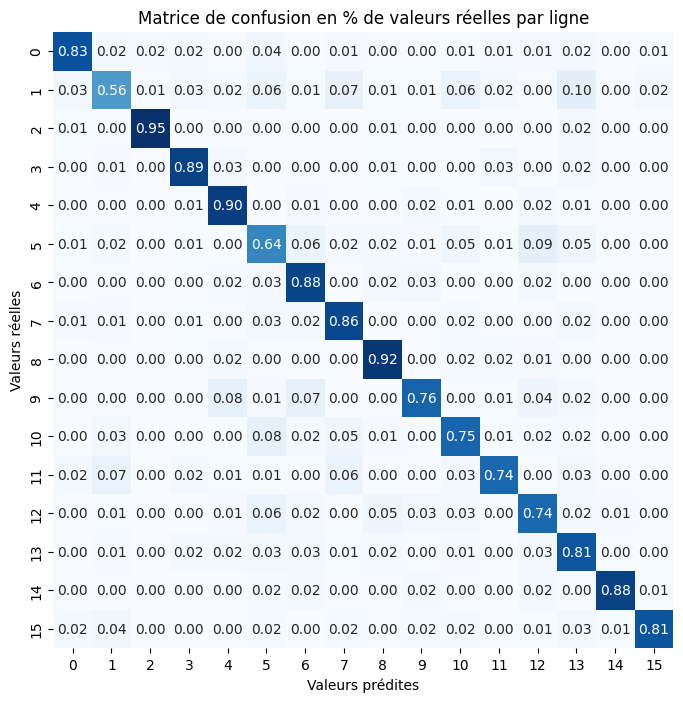

Accuracy: 0.80775
F1-score: 0.807459848510334


In [9]:
#ploting a confusion matrix and f1-score
cm = confusion_matrix(df.target, df.prediction)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', cbar=False)
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion en % de valeurs réelles par ligne')
plt.show()

accuracy = accuracy_score(df.target, df.prediction)
f1 = f1_score(df.target, df.prediction, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'F1-score: {f1}')

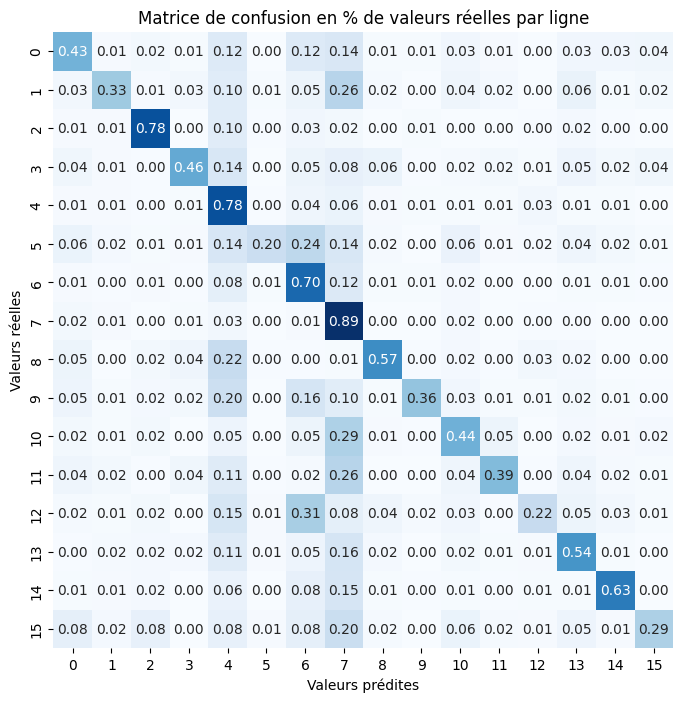

Accuracy: 0.5005
F1-score: 0.4986145533833714


In [7]:
#modele b1 efficientnet
#ploting a confusion matrix and f1-score
cm = confusion_matrix(df.target, df.prediction)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', cbar=False)
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion en % de valeurs réelles par ligne')
plt.show()

accuracy = accuracy_score(df.target, df.prediction)
f1 = f1_score(df.target, df.prediction, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'F1-score: {f1}')

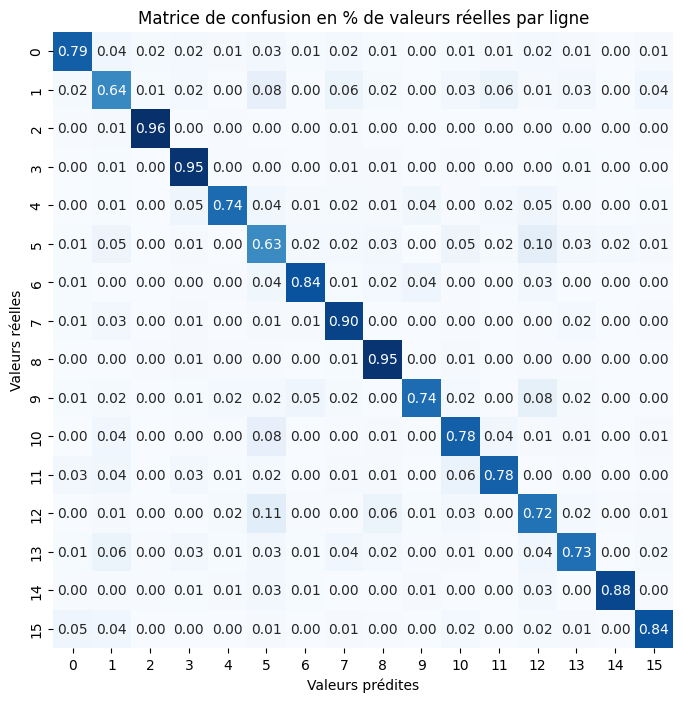

Accuracy: 0.8035
F1-score: 0.8043965297954779


In [9]:
#modele b1 efficientnet v2
#ploting a confusion matrix and f1-score
cm = confusion_matrix(df.target, df.prediction)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', cbar=False)
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion en % de valeurs réelles par ligne')
plt.show()

accuracy = accuracy_score(df.target, df.prediction)
f1 = f1_score(df.target, df.prediction, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'F1-score: {f1}')

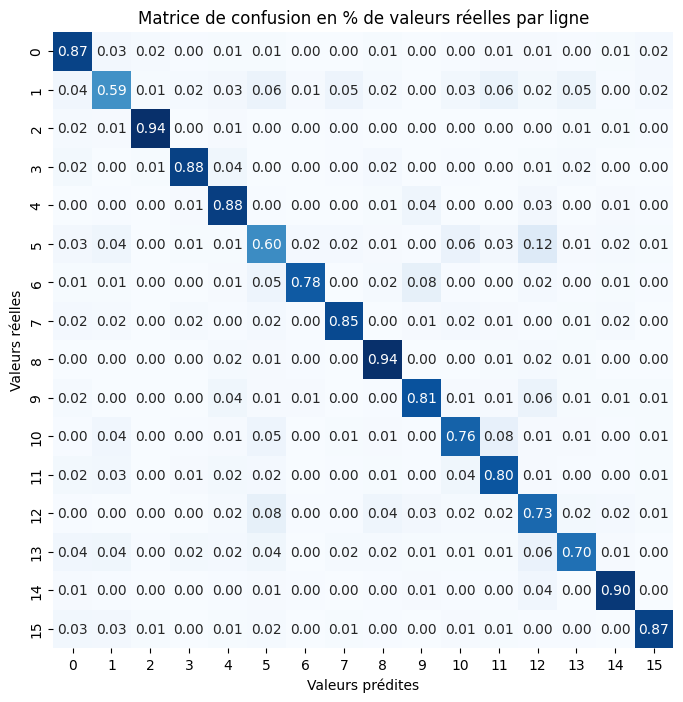

Accuracy: 0.8065
F1-score: 0.8060198896284406


In [22]:
#modele b1 efficientnet epoch 29
#ploting a confusion matrix and f1-score
cm = confusion_matrix(df.target, df.prediction)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', cbar=False)
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion en % de valeurs réelles par ligne')
plt.show()

accuracy = accuracy_score(df.target, df.prediction)
f1 = f1_score(df.target, df.prediction, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'F1-score: {f1}')

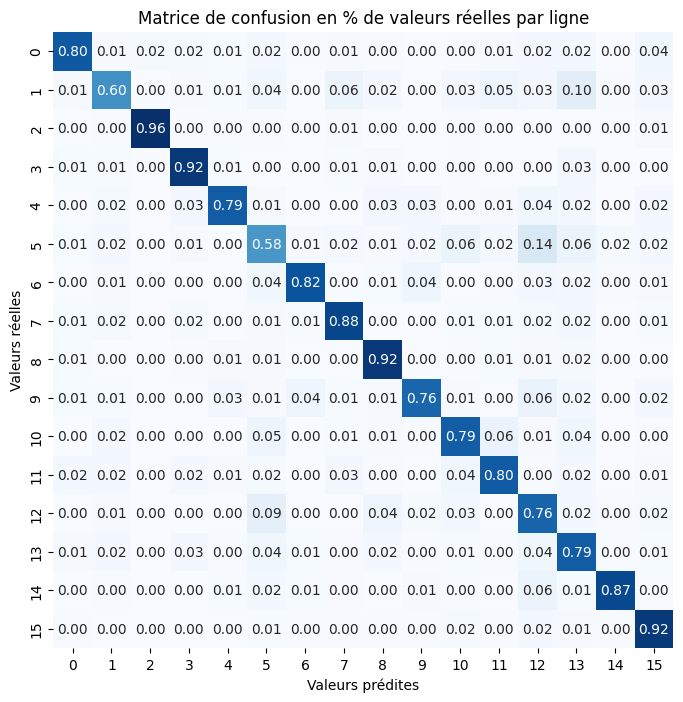

Accuracy: 0.81
F1-score: 0.810605253172714


In [26]:
#modele b1 efficientnet epoch 23
#ploting a confusion matrix and f1-score
cm = confusion_matrix(df.target, df.prediction)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', cbar=False)
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion en % de valeurs réelles par ligne')
plt.show()

accuracy = accuracy_score(df.target, df.prediction)
f1 = f1_score(df.target, df.prediction, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'F1-score: {f1}')

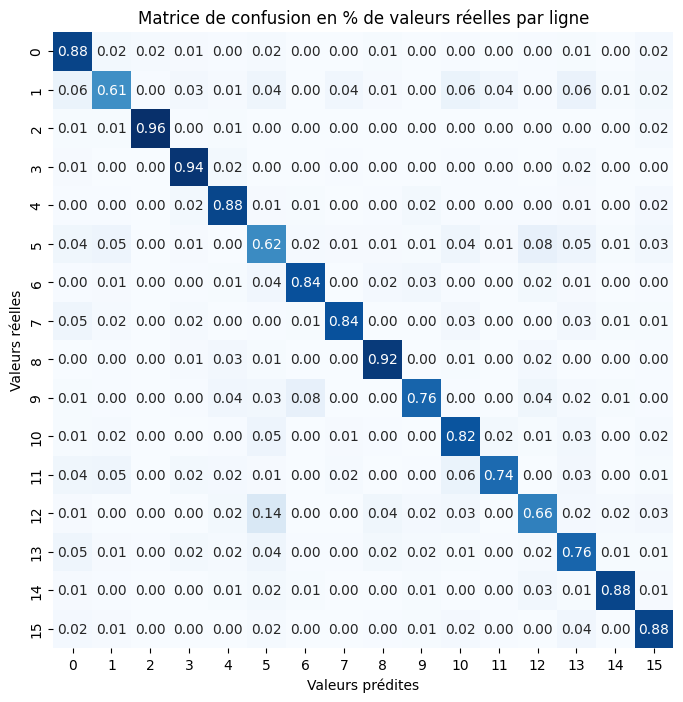

Accuracy: 0.8115
F1-score: 0.811109367344511


In [30]:
#modele b1 efficientnet epoch 21
#ploting a confusion matrix and f1-score
cm = confusion_matrix(df.target, df.prediction)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', cbar=False)
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion en % de valeurs réelles par ligne')
plt.show()

accuracy = accuracy_score(df.target, df.prediction)
f1 = f1_score(df.target, df.prediction, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'F1-score: {f1}')

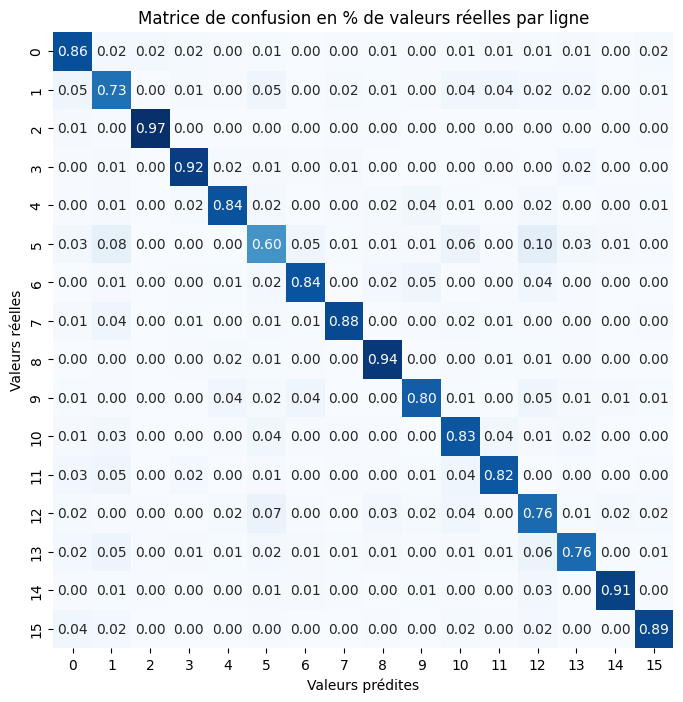

Accuracy: 0.83375
F1-score: 0.8341931470406941


In [9]:
#modele b1 efficientnet epoch 27 big train
#ploting a confusion matrix and f1-score
cm = confusion_matrix(df.target, df.prediction)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', cbar=False)
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion en % de valeurs réelles par ligne')
plt.show()

accuracy = accuracy_score(df.target, df.prediction)
f1 = f1_score(df.target, df.prediction, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'F1-score: {f1}')

In [ ]:
#modele b1 efficientnet v2
#ploting a confusion matrix and f1-score
cm = confusion_matrix(df.target, df.prediction)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', cbar=False)
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion en % de valeurs réelles par ligne')
plt.show()

accuracy = accuracy_score(df.target, df.prediction)
f1 = f1_score(df.target, df.prediction, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'F1-score: {f1}')

In [8]:
df.head()

,filename,picture,target,picture_resize,ocr_text,clean_text,cnn_processed_images,prediction
0,0000001053.tif,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",15,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","- August 20, 1985 To: R. A. Blott - & “ete T....",august ete knoop hughes zolper parker subject ...,"(True, None, [[tensor([[1., 1., 1., ..., 1., ...",13
1,0000019961.tif,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",. SAMPLE SPECIFICA’ o4 IFICATIONS ‘be A-o17 4 ...,sample date manufacture cigarette code pack co...,"(True, None, [[tensor([[0.0745, 0.0745, 0.0745...",7
2,0000036806.tif,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",15,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","MEMORANDI December 28, 1979 TO: TAN Corporat...",december tan corporate coordinator charles mcc...,"(True, None, [[tensor([[0.0000, 0.0000, 0.0000...",10
3,0000037987.tif,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",10,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",Cc Cc INFORMATION SYSTEMS Balance Sheet Marc...,information system balance sheet march asset c...,"(True, None, [[tensor([[1., 1., 1., ..., 1., ...",10
4,0000055301.tif,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",9,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",Our High Standards of Living Hard on Liver pa...,high standard live hard liver pane row site,"(True, None, [[tensor([[1.0000, 0.9765, 0.9843...",4


In [9]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [10]:
dataset = df.cnn_processed_images

In [17]:
dataset[0]

(True,
 None,
 tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
 
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
 
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]]]))

In [12]:
BATCH_SIZE = 16

In [18]:
dataset = []

for index, row in tqdm(df.iterrows()):
    dataset.append([row['cnn_processed_images'][2],row['target']])


4000it [00:00, 15018.81it/s]


In [24]:
# Split dataset
train_size = int(0.5 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
BATCH_SIZE = 1
gen = torch.Generator()
gen.manual_seed(0)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=gen)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [25]:
import torch.nn as nn
import torchvision.models as models
torch.cuda.empty_cache()

In [26]:
# Load the pre-trained EfficientNetB0 model
model_b1_t = models.efficientnet_b1(pretrained=True)

# Modify the classifier to fit our number of classes
model_b1_t.classifier[1] = nn.Linear(model_b1_t.classifier[1].in_features, 16)
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_b1_t.to(device)


c:\Users\sofia\Documents\Datascientest\Classification_project\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sofia\Documents\Datascientest\Classification_project\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [29]:
import torch.optim as optim

# Initialize loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_b1_t.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model_b1_t.train()
    running_loss = 0.0
    for images, labels in train_dataset:
        #images, labels = images.to(device), labels.to(device)  # Move data to device
        #print(images)
        optimizer.zero_grad()
        outputs = model_b1_t(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
optimizer = optim.Adam(model_b0.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model_b0.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device
        optimizer.zero_grad()
        outputs = model_b0(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")